In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 

import numpy as np
import glob
import os
import random

import matplotlib.pyplot as plt 

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
! git clone https://github.com/Taariq78/voxelmorph.git

In [ ]:
from voxelmorph.pytorch.model import SpatialTransformer

In [ ]:
import train

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

#'''unet_start'''
#        '''encoder'''
        self.conv_0=nn.Conv2d(2,16,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_1=nn.Conv2d(16,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_2=nn.Conv2d(32,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_3=nn.Conv2d(32,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))

        self.activation=nn.LeakyReLU(negative_slope=0.2)
        

#        '''decoder'''
        self.conv_0_dec=nn.Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_1_dec=nn.Conv2d(64,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_2_dec=nn.Conv2d(64,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_3_dec=nn.Conv2d(48,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_4_dec=nn.Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_5_dec=nn.Conv2d(34,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))

#        '''upsample'''
        self.upsample=nn.Upsample(scale_factor=2.0, mode='nearest')
#'''unet_end'''

        self.conv_vm2=nn.Conv2d(16,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.conv_flow=nn.Conv2d(16,2,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.spatial_transform = SpatialTransformer((256,256))

    def Unet(self, image_pair):
#          '''encode'''
      x1=self.conv_0(image_pair)
      x1=self.activation(x1)

      x2=self.conv_1(x1)
      x2=self.activation(x2)

      x3=self.conv_2(x2)
      x3=self.activation(x3)

      x4=self.conv_3(x3)
      x4=self.activation(x4)

#          '''decode'''
      y=self.conv_0_dec(x4)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x3],1)

      y=self.conv_1_dec(y)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x2],1)

      y=self.conv_2_dec(y)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x1],1)

      y=self.conv_3_dec(y)
      y=self.activation(y)          
      y=self.conv_4_dec(y)
      y=self.activation(y)

      y=self.upsample(y)
      y=torch.cat([y,image_pair],1)
      y=self.conv_5_dec(y)
      y=self.activation(y)

      y=self.conv_vm2(y)
      y=self.activation(y)

      return y

    def forward(self,mov,fix):
      z = torch.cat([mov, fix], dim=1)
      z = self.Unet(z)
      #print(z.shape)
      flow = self.conv_flow(z)
      #print(flow.shape)

      z=self.spatial_transform(mov,flow)   

      return z, flow  



model=Net().to(device)

In [ ]:
model=Net()
model.to(device)

Net(
  (conv_0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_1): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (activation): LeakyReLU(negative_slope=0.2)
  (conv_0_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_dec): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_dec): Conv2d(34, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (conv_vm2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_flo

In [ ]:
data_dir='/content/drive/My Drive/2020/Thesis/Data/Voxel_Training/Siddon/Chest/Patient_X'
train_vol_names = glob.glob(os.path.join(data_dir, '*.npz'))

In [ ]:
random.shuffle(train_vol_names)

In [ ]:
ten_split = np.array_split(train_vol_names, 10)

In [ ]:
fold_0 = ten_split[0]
fold_1 = ten_split[1]
fold_2 = ten_split[2]
fold_3 = ten_split[3]
fold_4 = ten_split[4]
fold_5 = ten_split[5]
fold_6 = ten_split[6]
fold_7 = ten_split[7]
fold_8 = ten_split[8]
fold_9 = ten_split[9]

In [ ]:
set_0 = []
'''holdout - fold 0'''
for g in range(0,10):
  if g == 0:
    continue
  set_0.extend(ten_split[g]) 

In [ ]:
set_1 = []
'''holdout - fold 1'''
for g in range(0,10):
  if g == 1:
    continue
  set_1.extend(ten_split[g]) 

In [ ]:
set_2 = []
'''holdout - fold 2'''
for g in range(0,10):
  if g == 2:
    continue
  set_2.extend(ten_split[g]) 

In [ ]:
set_3 = []
'''holdout - fold 3'''
for g in range(0,10):
  if g == 3:
    continue
  set_3.extend(ten_split[g]) 

In [ ]:
set_4 = []
'''holdout - fold 4'''
for g in range(0,10):
  if g == 4:
    continue
  set_4.extend(ten_split[g]) 

In [ ]:
set_5 = []
'''holdout - fold 5'''
for g in range(0,10):
  if g == 5:
    continue
  set_5.extend(ten_split[g]) 

In [ ]:
set_6 = []
'''holdout - fold 6'''
for g in range(0,10):
  if g == 6:
    continue
  set_6.extend(ten_split[g]) 

In [ ]:
set_7 = []
'''holdout - fold 7'''
for g in range(0,10):
  if g == 7:
    continue
  set_7.extend(ten_split[g]) 

In [ ]:
set_8 = []
'''holdout - fold 8'''
for g in range(0,10):
  if g == 8:
    continue
  set_8.extend(ten_split[g]) 

In [ ]:
set_9 = []
'''holdout - fold 9'''
for g in range(0,10):
  if g == 9:
    continue
  set_9.extend(ten_split[g]) 

In [ ]:
'''Training - hold out fold 0 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_0
train_vol_names = set_0
EPOCH=30

In [ ]:
losses_0, validation_0=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:338
loss(total):0.005045
recons_loss:0.009909
grad_loss:0.003214
dice_loss:-0.807830
---------------------------------------

Epoch:7
Batch_number:339
loss(total):0.012083
recons_loss:0.015457
grad_loss:0.004625
dice_loss:-0.799844
---------------------------------------

Epoch:7
Batch_number:340
loss(total):0.010124
recons_loss:0.014153
grad_loss:0.004340
dice_loss:-0.836910
---------------------------------------

Epoch:7
Batch_number:341
loss(total):0.008205
recons_loss:0.011949
grad_loss:0.004184
dice_loss:-0.792770
---------------------------------------

Epoch:7
Batch_number:342
loss(total):0.013651
recons_loss:0.015907
grad_loss:0.005633
dice_loss:-0.788911
---------------------------------------

Epoch:7
Batch_number:343
loss(total):0.009970
recons_loss:0.013712
grad_loss:0.004690
dice_loss:-0.843160
---------------------------------------

Epoch:7
Batch_number:344
loss(total):0.015093
recons_loss:0.017567
grad_los

<function matplotlib.pyplot.show>

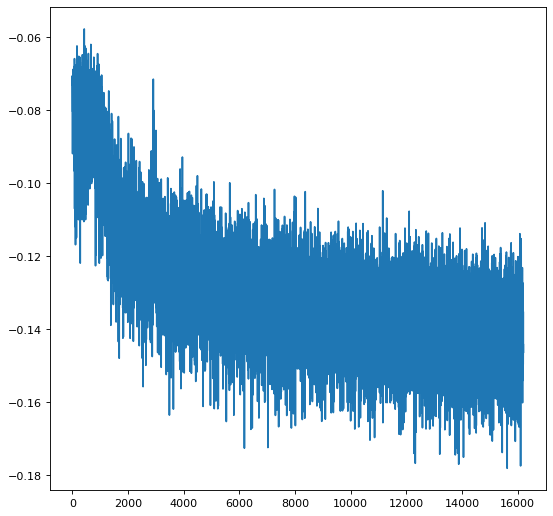

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_0[1:])
plt.show

<function matplotlib.pyplot.show>

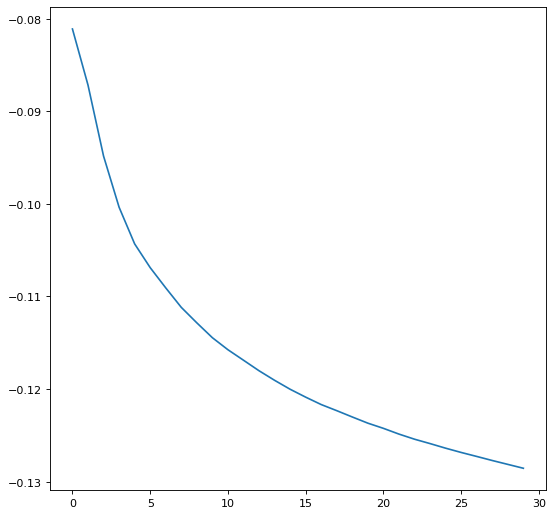

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_0)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_0)):
  with open('CC_validation_0.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_0[h].numpy()])

In [ ]:
import pandas as pd
v = pd.read_csv("/content/CC_validation_0.csv")

In [ ]:
v

,0,-0.08110355
0,1,-0.087163
1,2,-0.094831
2,3,-0.100362
3,4,-0.104320
4,5,-0.106887
5,6,-0.109074
6,7,-0.111180
7,8,-0.112853
8,9,-0.114457
9,10,-0.115757


In [ ]:
'''Training - hold out fold 1 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_1
train_vol_names = set_1
EPOCH=30

In [ ]:
losses_1, validation_1=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

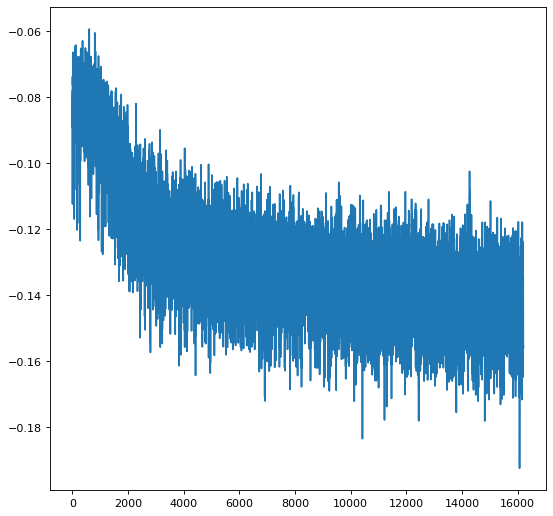

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_1[1:])
plt.show

<function matplotlib.pyplot.show>

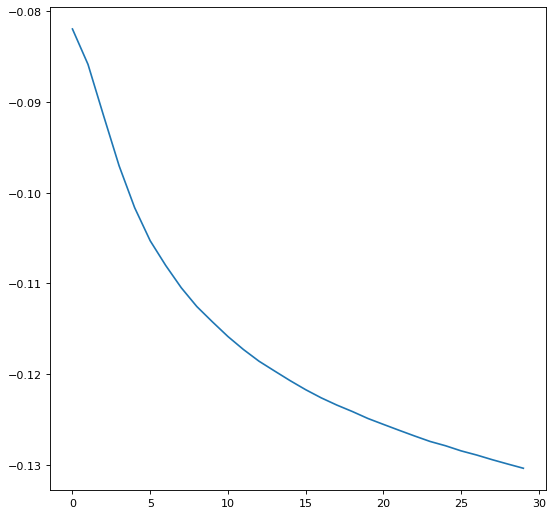

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_1)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_1)):
  with open('CC_validation_1.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_1[h].numpy()])

In [ ]:
'''Training - hold out fold 2 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_2
train_vol_names = set_2
EPOCH=30

In [ ]:
losses_2, validation_2=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

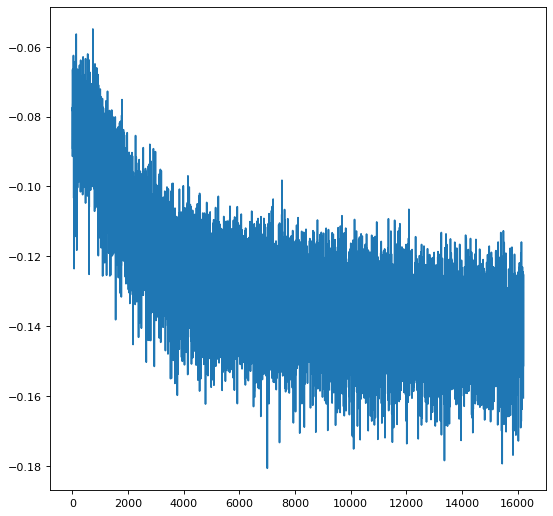

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_2[1:])
plt.show

<function matplotlib.pyplot.show>

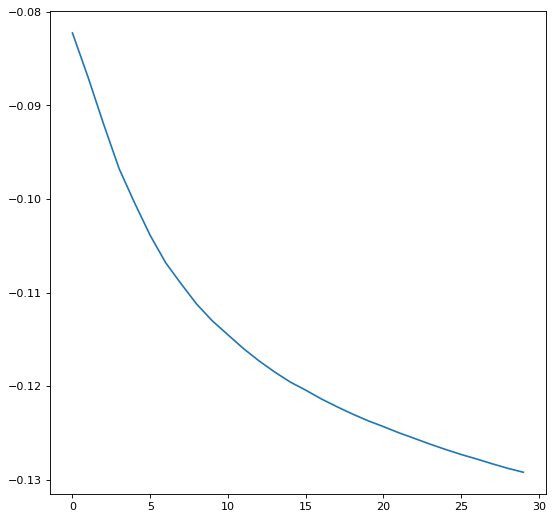

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_2)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_2)):
  with open('CC_validation_2.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_2[h].numpy()])

In [ ]:
'''Training - hold out fold 3 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_3
train_vol_names = set_3
EPOCH=30

In [ ]:
losses_3, validation_3=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

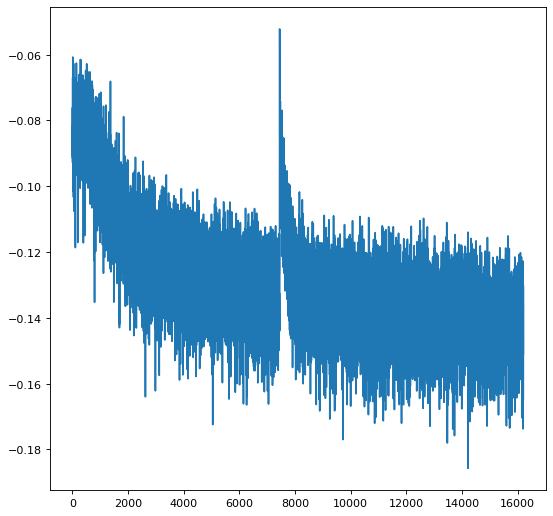

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_3[1:])
plt.show

<function matplotlib.pyplot.show>

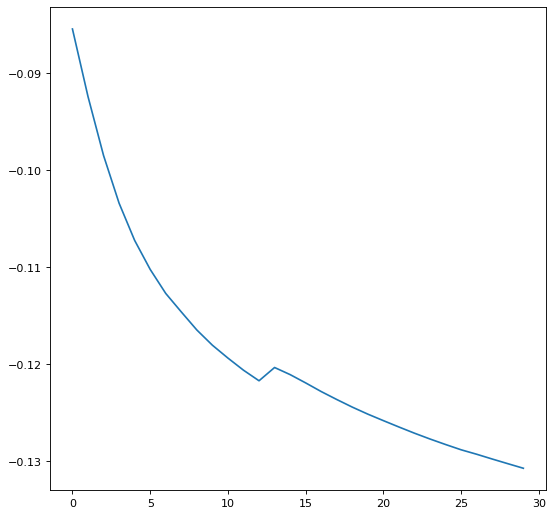

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_3)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_3)):
  with open('CC_validation_3.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_3[h].numpy()])

In [ ]:
'''Training - hold out fold 4 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_4
train_vol_names = set_4
EPOCH=30

In [ ]:
losses_4, validation_4=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

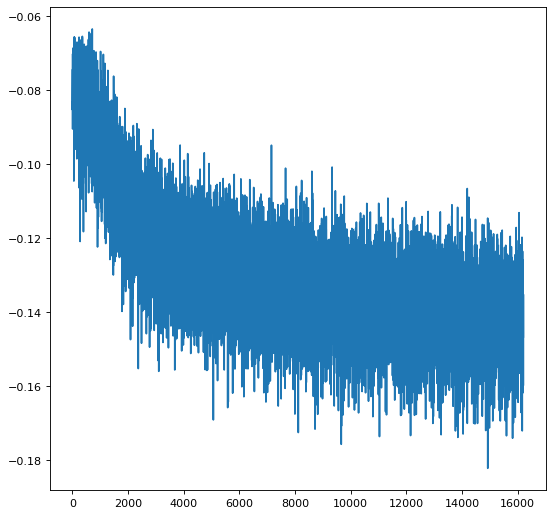

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_4[1:])
plt.show

<function matplotlib.pyplot.show>

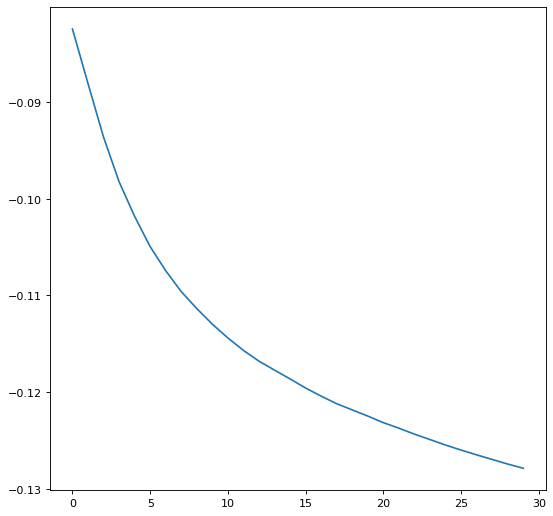

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_4)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_4)):
  with open('CC_validation_4.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_4[h].numpy()])

In [ ]:
'''Training - hold out fold 5 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_5
train_vol_names = set_5
EPOCH=30

In [ ]:
losses_5, validation_5=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

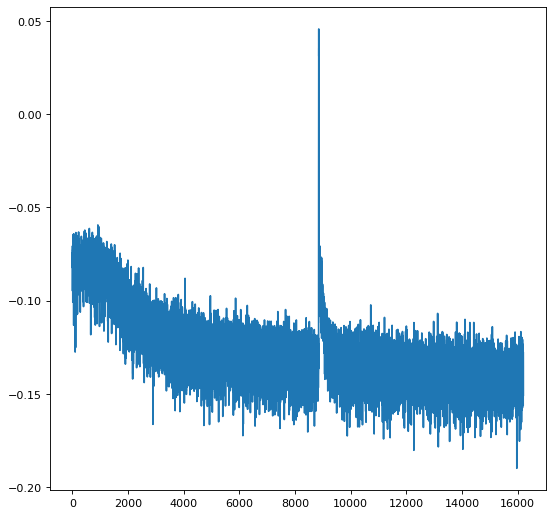

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_5[1:])
plt.show

<function matplotlib.pyplot.show>

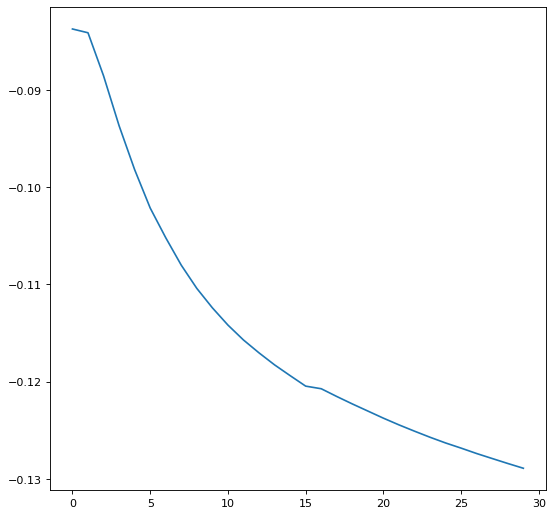

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_5)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_5)):
  with open('CC_validation_5.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_5[h].numpy()])

In [ ]:
'''Training - hold out fold 6 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_6
train_vol_names = set_6
EPOCH=30

In [ ]:
losses_6, validation_6=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

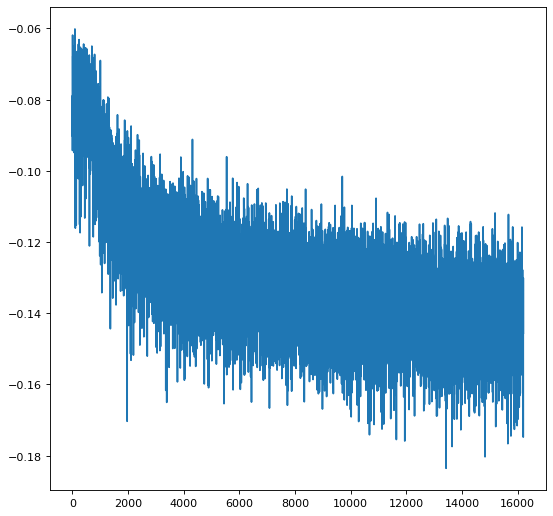

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_6[1:])
plt.show

<function matplotlib.pyplot.show>

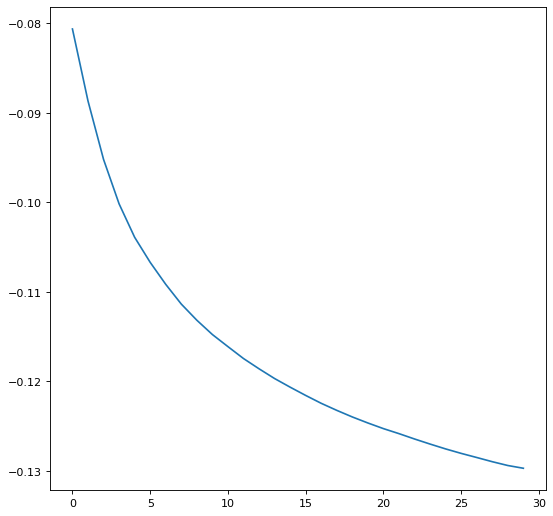

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_6)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_6)):
  with open('CC_validation_6.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_6[h].numpy()])

In [ ]:
'''Training - hold out fold 7 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_7
train_vol_names = set_7
EPOCH=30

In [ ]:
losses_7, validation_7=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

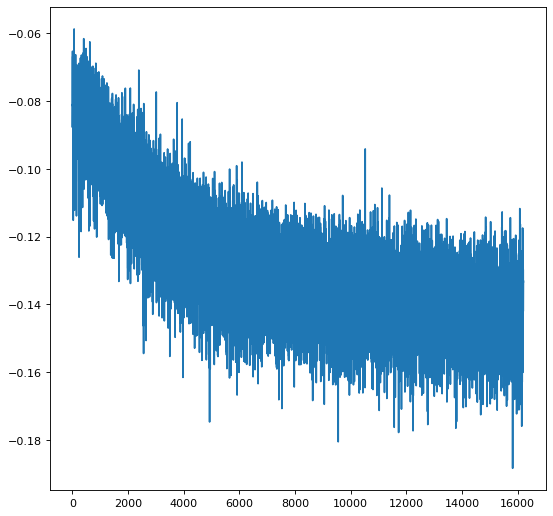

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_7[1:])
plt.show

<function matplotlib.pyplot.show>

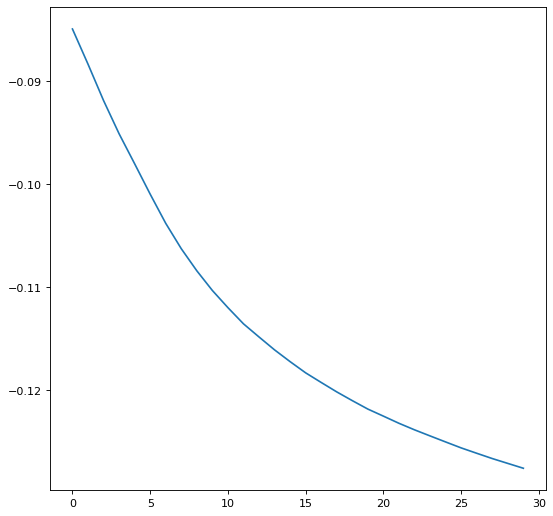

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_7)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_7)):
  with open('CC_validation_7.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_7[h].numpy()])

In [ ]:
'''Training - hold out fold 8 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_8
train_vol_names = set_8
EPOCH=30

In [ ]:
losses_8, validation_8=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

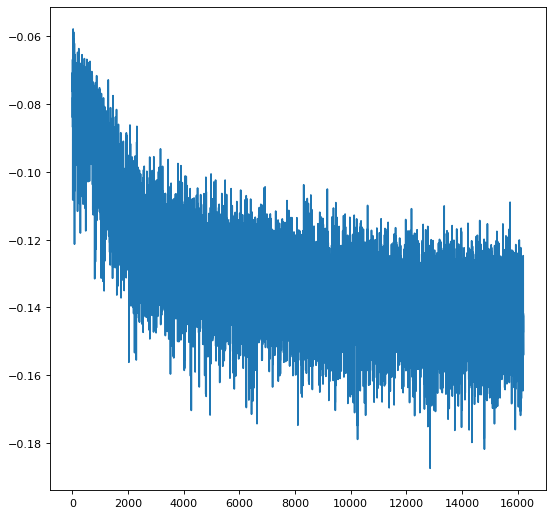

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_8[1:])
plt.show

<function matplotlib.pyplot.show>

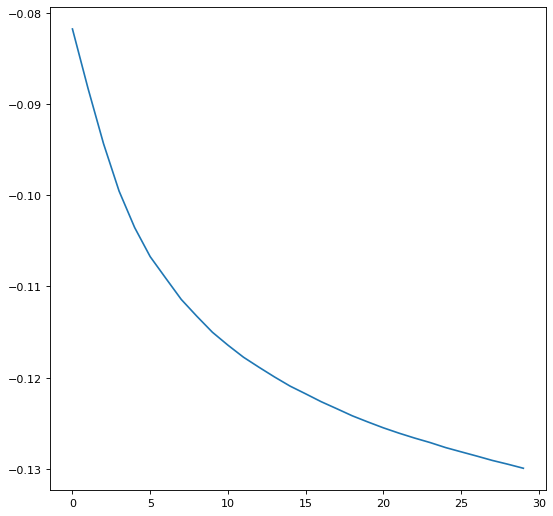

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_8)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_8)):
  with open('CC_validation_8.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_8[h].numpy()])

In [ ]:
'''Training - hold out fold 9 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='ncc'
model='vm2'
reg_param=1
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_9
train_vol_names = set_9
EPOCH=30

In [ ]:
losses_9, validation_9=train.train(gpu,train_vol_names,
          atlas_file,
          lr,
          n_iter,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),valid,EPOCH)

<function matplotlib.pyplot.show>

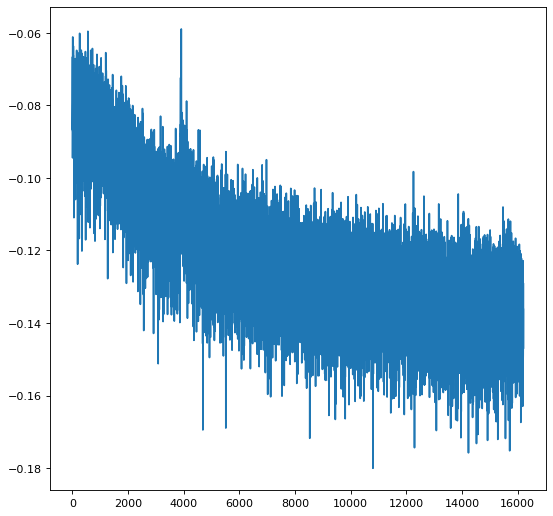

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_9[1:])
plt.show

<function matplotlib.pyplot.show>

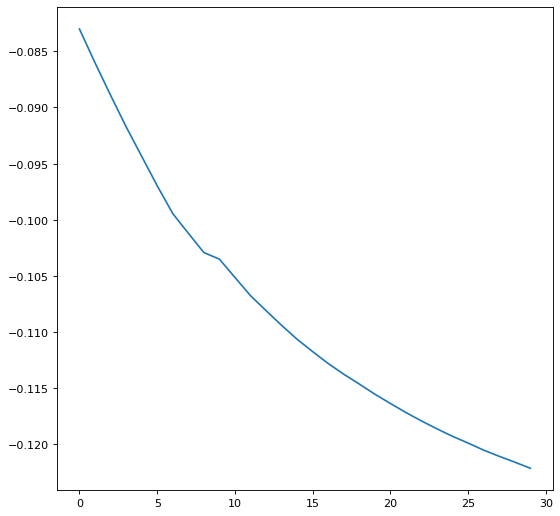

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_9)
plt.show

In [ ]:
import csv
for h in range(0,len(validation_9)):
  with open('CC_validation_9.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, validation_9[h].numpy()])